<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imporando-Pacotes" data-toc-modified-id="Imporando-Pacotes-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imporando Pacotes</a></span></li><li><span><a href="#Função-de-Entrada" data-toc-modified-id="Função-de-Entrada-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Função de Entrada</a></span></li><li><span><a href="#Dicionários" data-toc-modified-id="Dicionários-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Dicionários</a></span></li><li><span><a href="#Cenários" data-toc-modified-id="Cenários-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Cenários</a></span></li><li><span><a href="#Otimização" data-toc-modified-id="Otimização-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Otimização</a></span></li></ul></div>

# Imporando Pacotes

In [1]:
# Importando as bibliotecas
import numpy as np # pacote para funções matemáticas
import pandas as pd # pacote para a manipulação dos dados em tabela
import warnings
import itertools
from IPython.display import display # Allows the use of display() for DataFrames
import matplotlib.pyplot as plt # pacote para fazer gráficos
import matplotlib.patches as mpatches
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
import plotly.graph_objects as go
import scikitplot as skplt
import sqlite3 as sql

import pandas_ta as ta
import talib

import mplfinance as mpf

import optuna
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

pd.set_option("display.max_columns", 40)
pd.set_option('display.max_rows', 500)

C:\Users\User\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\User\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
from futures_backtester import Backtester

# Função de Entrada

In [17]:
def entrada(df, bb_length, std, allowed_hours=None, position_type="both"):
    """
    Estratégia baseada em Bandas de Bollinger.
    
    Args:
        df (pandas.DataFrame): DataFrame com dados OHLC.
        bb_length (int): Período para cálculo da média e desvio padrão.
        std (float): Número de desvios padrão para as bandas.
        allowed_hours (list): Horas que vamos executar a estratégia.
        position_type (str): Tipo de posições permitidas:
                            - "long": Apenas posições de compra (+1)
                            - "short": Apenas posições de venda (-1)
                            - "both": Ambas as posições (padrão)
        
    Returns:
        pandas.Series: Posições (-1=short, 0=neutro, 1=long)
    """
    df = df.copy()  # Para evitar SettingWithCopyWarning
    
    aux = df.ta.bbands(length=bb_length, std=std)
    df[f"BBL_{bb_length}_{std}"] = aux[f"BBL_{bb_length}_{std}"]
    df[f"BBU_{bb_length}_{std}"] = aux[f"BBU_{bb_length}_{std}"]
    df[f"BBM_{bb_length}_{std}"] = aux[f"BBM_{bb_length}_{std}"]    
    
    # Inicializar a coluna de posição com zeros
    df['position'] = 0
    
    # Calculando entradas (buy/sell)
    cond1 = (df.close < df[f"BBL_{bb_length}_{std}"]) & (df.close.shift(+1) >= df[f"BBL_{bb_length}_{std}"].shift(+1))
    cond2 = (df.close > df[f"BBU_{bb_length}_{std}"]) & (df.close.shift(+1) <= df[f"BBU_{bb_length}_{std}"].shift(+1))
    
    # Aplicar as posições de acordo com o parâmetro position_type
    if position_type.lower() == "both":
        df.loc[cond1, "position"] = -1
        df.loc[cond2, "position"] = +1
    elif position_type.lower() == "long":
        df.loc[cond2, "position"] = +1
    elif position_type.lower() == "short":
        df.loc[cond1, "position"] = -1
    else:
        raise ValueError("position_type deve ser 'long', 'short' ou 'both'")
    
    # Restrição de horários
    if allowed_hours is not None:
        # Zera posição fora dos horários permitidos
        current_hours = df.index.to_series().dt.hour
        df.loc[~current_hours.isin(allowed_hours), 'position'] = 0
    
    return df['position']


# Dicionários

In [18]:



path_b3 = 'C:/Users/User/OneDrive/Documentos/rnt/Finance/Trading Projects/00.database/candlestick data/futuros/'
path_tickmill = 'C:/Users/User/OneDrive/Documentos/rnt/Finance/Trading Projects/00.database/tickmill/forex/'

dict_custos = {'WIN@N':0.2*5, 'WDO@N':2.40/2,
                                     'AUDUSD': 3,
                                     'EURUSD': 3,
                                     'GBPUSD': 3,
                                     'NZDUSD': 3,
                                     'USDCHF': 3,
                                     'USDJPY': 3,
                                     'AUDCAD': 3,
                                     'AUDCHF': 3,
                                     'AUDJPY': 3,
                                     'AUDNZD': 3,
                                     'CADCHF': 3,
                                     'CADJPY': 3,
                                     'CHFJPY': 3,
                                     'EURAUD': 3,
                                     'EURCAD': 3,
                                     'EURCHF': 3,
                                     'EURGBP': 3,
                                     'EURHKD': 3,
                                     'EURJPY': 3,
                                     'EURMXN': 3,
                                     'EURNZD': 3,
                                     'EURTRY': 3,
                                     'GBPCAD': 3,
                                     'GBPCHF': 3,
                                     'GBPJPY': 3,
                                     'USDCNH': 3,
                                     'USDCZK': 3,
                                     'USDMXN': 3,
                                     'USDTRY': 3,
                                     'XAGUSD': 3,
                                     'XAUUSD': 3,
                                     'STOXX50': 3,
                                     'UK100': 3,
                                     'FRANCE40': 3,
                                     'VIX': 3,
                                     'ALUMINIUM': 3,
                                     'PLATINUM': 3,
                                     'LEAD': 3,
                                     'NICKEL': 3,
                                     'PALLADIUM': 3,
                                     'ZINC': 3,
                                     'COPPER': 3,
                                     'DXY': 3,
                                     'COCOA': 3,
                                     'SUGAR': 3,
                                     'WHEAT': 3,
                                     'US500': 3,
                                     'NAT.GAS': 3,
                                     'BRENT': 3,
                                     'EEM': 3,
                                     'EWZ': 3,
                                     'IWM': 3,
                                     'TLT': 3,
                                     'SPY': 3,
                                     'DIA': 3}

dict_valor_lot = {'WIN@N':0.2, 'WDO@N':10.0,
                                'USDCAD': 100000,
                                 'AUDUSD': 100000,
                                 'EURUSD': 100000,
                                 'GBPUSD': 100000,
                                 'NZDUSD': 100000,
                                 'USDCHF': 100000,
                                 'USDJPY': 100000,
                                 'AUDCAD': 100000,
                                 'AUDCHF': 100000,
                                 'AUDJPY': 100000,
                                 'AUDNZD': 100000,
                                 'CADCHF': 100000,
                                 'CADJPY': 100000,
                                 'CHFJPY': 100000,
                                 'EURAUD': 100000,
                                 'EURCAD': 100000,
                                 'EURCHF': 100000,
                                 'EURGBP': 100000,
                                 'EURHKD': 100000,
                                 'EURJPY': 100000,
                                 'EURMXN': 100000,
                                 'EURNZD': 100000,
                                 'EURTRY': 100000,
                                 'GBPCAD': 100000,
                                 'GBPCHF': 100000,
                                 'GBPJPY': 100000,
                                 'USDCNH': 100000,
                                 'USDCZK': 100000,
                                 'USDMXN': 100000,
                                 'USDTRY': 100000,
                                 'XAGUSD': 100000,
                                 'XAUUSD': 100000,
                                 'STOXX50': 100000,
                                 'UK100': 100000,
                                 'FRANCE40': 100000,
                                 'VIX': 100000,
                                 'ALUMINIUM': 100000,
                                 'PLATINUM': 100000,
                                 'LEAD': 100000,
                                 'NICKEL': 100000,
                                 'PALLADIUM': 100000,
                                 'ZINC': 100000,
                                 'COPPER': 100000,
                                 'DXY': 100000,
                                 'COCOA': 100000,
                                 'SUGAR': 100000,
                                 'WHEAT': 100000,
                                 'US500': 100000,
                                 'NAT.GAS': 100000,
                                 'BRENT': 100000,
                                 'EEM': 100000,
                                 'EWZ': 100000,
                                 'IWM': 100000,
                                 'TLT': 100000,
                                 'SPY': 100000,
                                 'DIA': 100000}

dict_path = {'WIN@N':path_b3, 'WDO@N':path_b3, 
                              'USDCAD': path_tickmill,
                             'AUDUSD': path_tickmill,
                             'EURUSD': path_tickmill,
                             'GBPUSD': path_tickmill,
                             'NZDUSD': path_tickmill,
                             'USDCHF': path_tickmill,
                             'USDJPY': path_tickmill,
                             'AUDCAD': path_tickmill,
                             'AUDCHF': path_tickmill,
                             'AUDJPY': path_tickmill,
                             'AUDNZD': path_tickmill,
                             'CADCHF': path_tickmill,
                             'CADJPY': path_tickmill,
                             'CHFJPY': path_tickmill,
                             'EURAUD': path_tickmill,
                             'EURCAD': path_tickmill,
                             'EURCHF': path_tickmill,
                             'EURGBP': path_tickmill,
                             'EURHKD': path_tickmill,
                             'EURJPY': path_tickmill,
                             'EURMXN': path_tickmill,
                             'EURNZD': path_tickmill,
                             'EURTRY': path_tickmill,
                             'GBPCAD': path_tickmill,
                             'GBPCHF': path_tickmill,
                             'GBPJPY': path_tickmill,
                             'USDCNH': path_tickmill,
                             'USDCZK': path_tickmill,
                             'USDMXN': path_tickmill,
                             'USDTRY': path_tickmill,
                             'XAGUSD': path_tickmill,
                             'XAUUSD': path_tickmill,
                             'STOXX50': path_tickmill,
                             'UK100': path_tickmill,
                             'FRANCE40': path_tickmill,
                             'VIX': path_tickmill,
                             'ALUMINIUM': path_tickmill,
                             'PLATINUM': path_tickmill,
                             'LEAD': path_tickmill,
                             'NICKEL': path_tickmill,
                             'PALLADIUM': path_tickmill,
                             'ZINC': path_tickmill,
                             'COPPER': path_tickmill,
                             'DXY': path_tickmill,
                             'COCOA': path_tickmill,
                             'SUGAR': path_tickmill,
                             'WHEAT': path_tickmill,
                             'US500': path_tickmill,
                             'NAT.GAS': path_tickmill,
                             'BRENT': path_tickmill,
                             'EEM': path_tickmill,
                             'EWZ': path_tickmill,
                             'IWM': path_tickmill,
                             'TLT': path_tickmill,
                             'SPY': path_tickmill,
                             'DIA': path_tickmill}

# Cenários

In [19]:
# 5 min - win'
{'sl': 1486, 'tp': 1134, 'BB_LENGTH': 10, 'STD': 1.84}
{'sl': 2471, 'tp': 1438, 'BB_LENGTH': 8, 'STD': 1.80}

# 5 min - wdo
{'sl': 29, 'tp': 27, 'BB_LENGTH': 9, 'STD': 1.2114296789710028}
{'sl': 12, 'tp': 11, 'BB_LENGTH': 7, 'STD': 1.405428218011036}

{'sl': 12, 'tp': 11, 'BB_LENGTH': 7, 'STD': 1.405428218011036}

In [133]:
params = {'sl': 280, 'tp': 1800, 'BB_LENGTH': 8, 'STD': 1.80}
params = {'sl': 8, 'tp': 15, 'BB_LENGTH': 7, 'STD': 1.405428218011036}
#params = {'sl': 1.5, 'tp': 28.6, 'BB_LENGTH': 7, 'STD': 0.9}
#params = {'tp': 29.5, 'sl': 2.6, 'BB_LENGTH': 7, 'STD': 1.0}
params = {'sl': 12, 'tp': 5, 'BB_LENGTH': 7, 'STD': 1.405428218011036}
params = {'sl': 25,
 'tp': 3.0,
 'BB_LENGTH': 9,
 'STD': 1.451487695156554}
#params = {'sl': 1, 'tp': 21.2, 'BB_LENGTH': 8, 'STD': 1.7}
#params = {'sl': 0.00400, 'tp': 0.00800, 'BB_LENGTH: 8, 'STD': 1.7}
#params = {'sl': 0.10000, 'tp': 0.30000, 'BB_LENGTH': 8, 'STD': 1.7}
#params = {'sl': 0.10000, 'tp': 0.20000, 'BB_LENGTH': 8, 'STD': 1.7}

In [134]:
# Configurar o backtester
sym = 'WDO@N'
#sym = 'EURUSD'
#sym = 'USDJPY'

bt = Backtester(
    symbol = sym,
    timeframe = 't5',
    data_ini='2019-01-01',
    data_fim='2025-12-31',
    tp = params['tp'],
    sl = params['sl'],
    slippage = 0,
    tc = dict_custos[sym], # $ per lot
    lote = 1.0,
    valor_lote= dict_valor_lot[sym],
    initial_cash = 30000,
    path_base= dict_path[sym],
    daytrade = False
)

# Parâmetros da estratégia RSI
BB_LENGTH = params['BB_LENGTH']
STD = params['STD']

# Executa o backtest com a estratégia RSI
results, metrics = bt.run(
    signal_function=entrada, 
    signal_args={
        "bb_length": BB_LENGTH,
        "std": STD,
        #'allowed_hours': [9,10,11,12,13,14,15,16,17],
        'allowed_hours': [12],
        'position_type':'both'
    }
)


# Print de métricas
bt.print_metrics(metrics)


===== RELATÓRIO DE DESEMPENHO =====
Símbolo: WDO@N | Timeframe: t5
Período: 2019-01-01 a 2025-12-31

--- RESULTADOS ---
Saldo Inicial: $30000.00
Saldo Final: $33395.60
Retorno Total: $3395.60 (11.32%)
Retorno Anualizado: 1.78%
Volatilidade Anualizada: 5.49%
Drawdown Máximo: 12.90%
Drawdown Máximo (Valor): $4325.60
Tempo Máximo em Drawdown: 110537.0 períodos
Tempo em Drawdown: 95.37% do total

--- TRADES ---
Total de Trades: 2781
Trades Vencedores: 2519 (90.58%)
Trades Perdedores: 262 (9.42%)
Saídas por TP: 90.58%
Saídas por SL: 9.42%
Saídas por Tempo: 0.00%

--- RATIOS ---
Sharpe Ratio: 0.324
Sortino Ratio: 0.582
Calmar Ratio: 0.138
Profit Factor: 1.051

--- ANÁLISE DE GANHOS/PERDAS ---
Ganho Médio: $27.60
Perda Média: $252.40
Win/Loss Ratio: 0.11
Expectancy: $1.22



<module 'matplotlib.pyplot' from 'C:\\Users\\User\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

<Figure size 1400x1000 with 0 Axes>

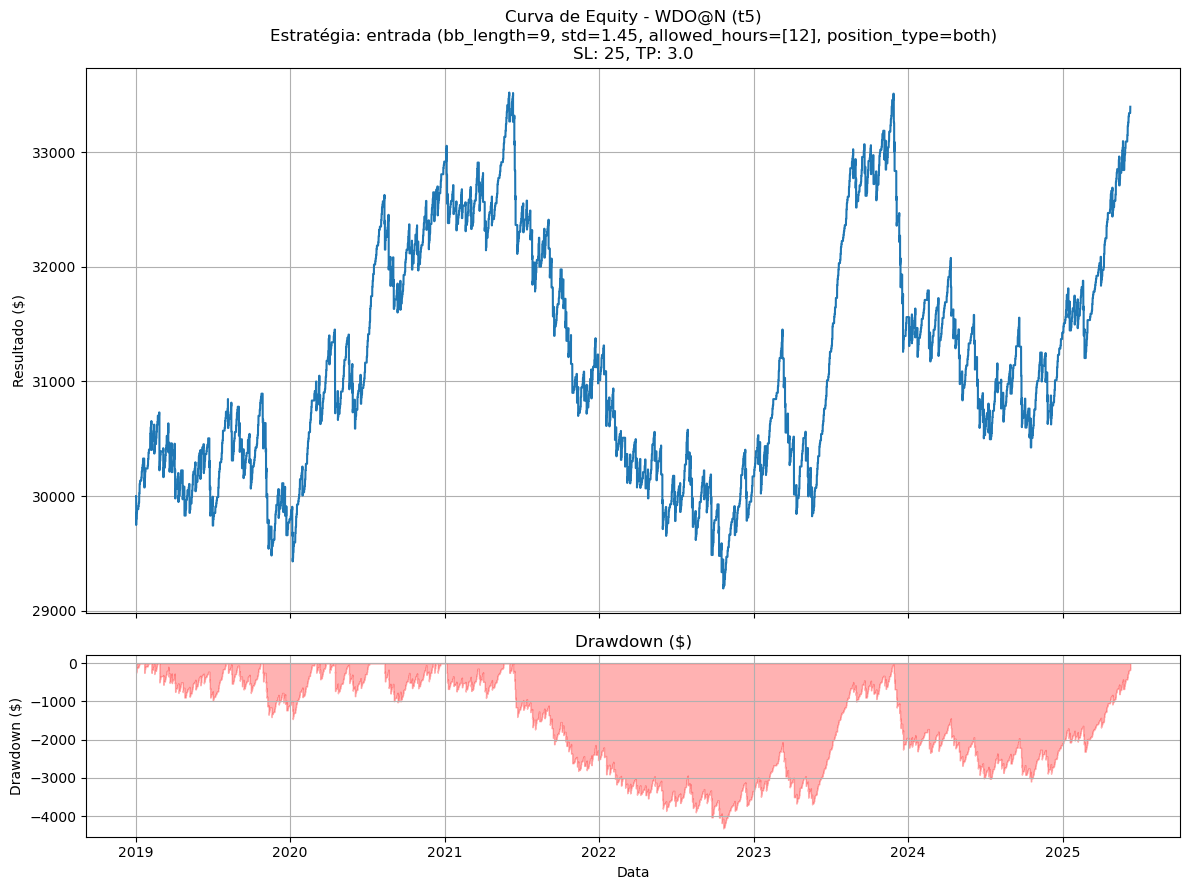

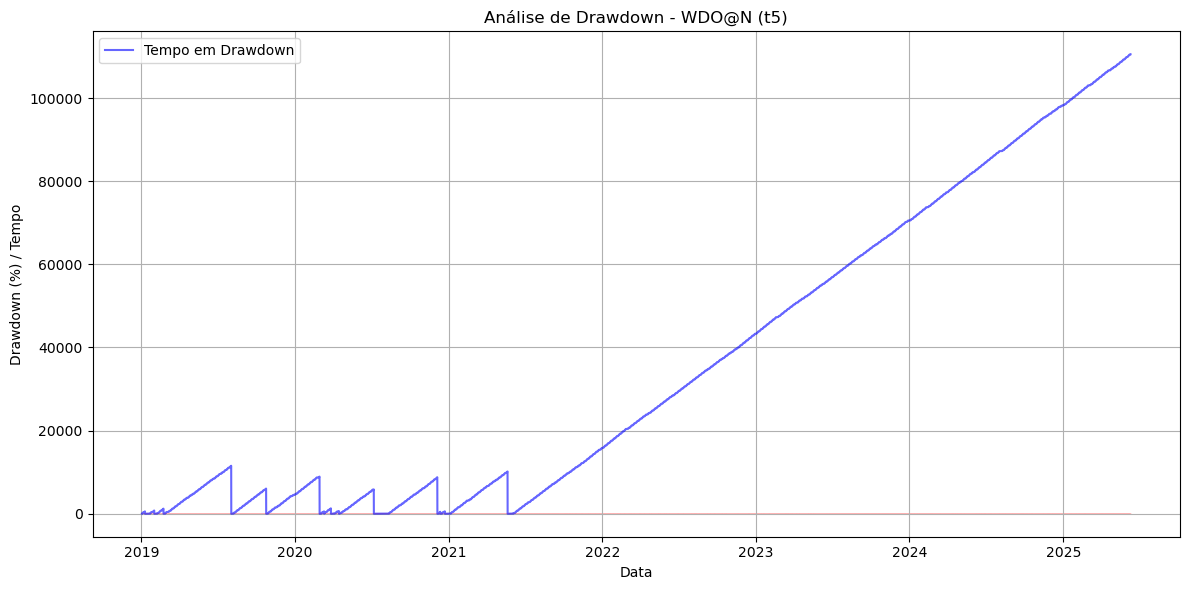

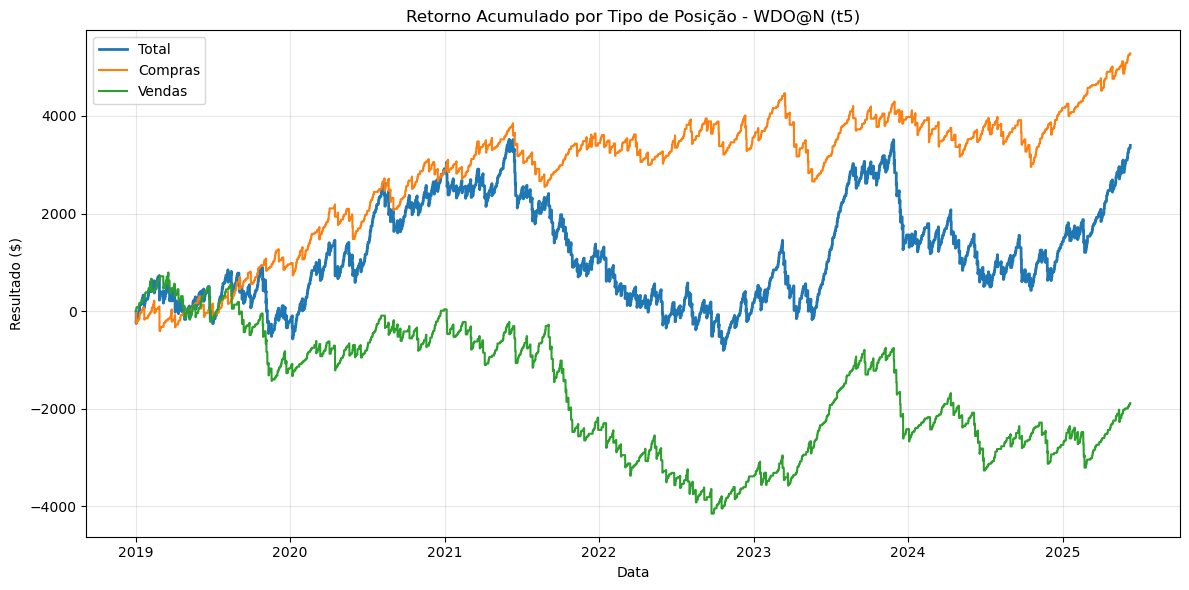

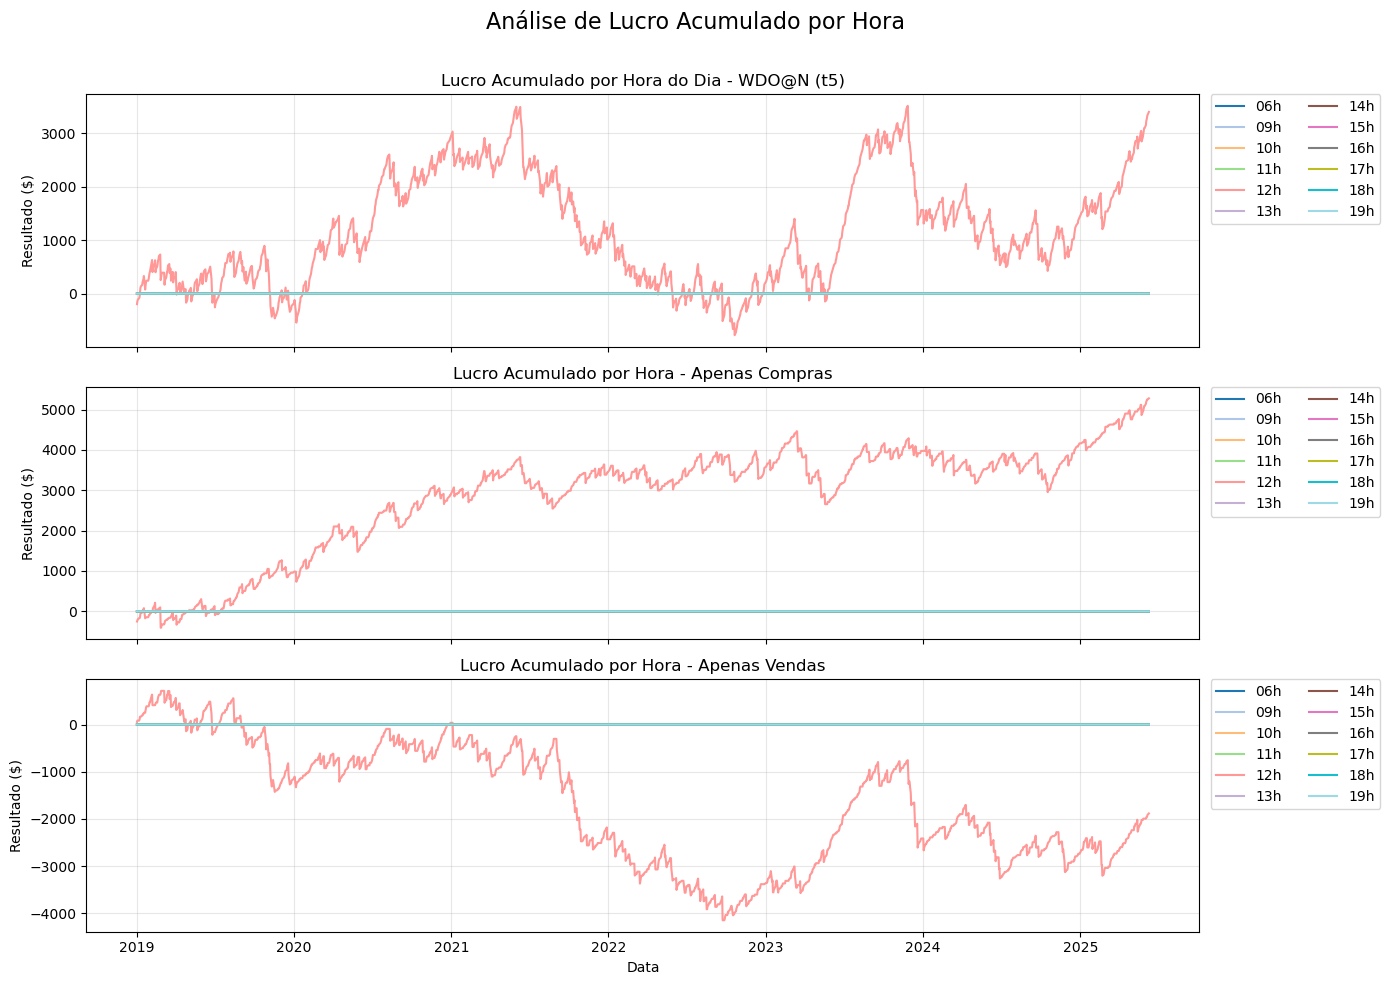

In [135]:
# Plotar a curva de equity com drawdown
plt.figure(figsize=(14, 10))

# 1. Curva de equity
plt = bt.plot_equity_curve(include_drawdown=True)

# 2. Análise detalhada de drawdown
plt = bt.plot_drawdown()

# 3. resultado por hora
bt.plot_by_position()
bt.plot_cumulative_by_hour()

In [27]:
#bt.plot_profit_by_hour()

# Otimização

In [158]:
metrics

{'total_return': 349825.0,
 'total_trades': 19190,
 'win_trades': 7859,
 'loss_trades': 11285,
 'win_rate': 0.4095362167795727,
 'tp_rate': 0.06175091193329859,
 'sl_rate': 0.47170401250651384,
 'time_exit_rate': 0.4665450755601876,
 'profit_factor': 1.2336442356178474,
 'max_drawdown': 1.0684931506849316,
 'max_drawdown_value': 20682.0,
 'max_time_underwater': 27241.0,
 'underwater_rate': 0.976249427725196,
 'sharpe_ratio': 1.3473779398793917,
 'sortino_ratio': 1086.439815934077,
 'calmar_ratio': 16.914466686007156,
 'avg_win': 235.02735717012342,
 'avg_loss': 132.67656180770936,
 'win_loss_ratio': 1.7714308689333764,
 'expectancy': 17.911510065494795}

In [118]:
def objective_ind(trial):  
    
    '''
    função para maximizar os ganhos no mini-indice
    '''

    # Configurar o backtester
    sym = 'WDO@N'
    bt = Backtester(
        symbol = sym,
        timeframe = 't5',
        data_ini = '2019-01-01',
        data_fim = '2025-12-31',
        sl = trial.suggest_float('sl', 1.0, 32.0),
        tp = trial.suggest_float('tp', 1.0, 32.0),
        slippage = 0,
        tc = dict_custos[sym], # $ per lot
        lote = 1,
        valor_lote= dict_valor_lot[sym],
        initial_cash = 30000,
        path_base= dict_path[sym],
        daytrade = True
    )
    
    # Parâmetros da estratégia RSI
    BB_LENGTH = trial.suggest_int('BB_LENGTH', 4, 10)
    STD = trial.suggest_float('STD', 1.0, 2.0)
    
    # Executa o backtest com a estratégia RSI
    _, metrics = bt.run(
        signal_function=entrada, 
        signal_args={
            "bb_length": BB_LENGTH,
            "std": STD,
            'allowed_hours': [12],
            'position_type':'both'
        }
    )

    
    metrica = metrics['sharpe_ratio']
    #metrica = metrics['max_drawdown_value']
        
    return metrica

In [119]:
study = optuna.create_study(direction="maximize")

study.optimize(objective_ind, n_trials=150)

[I 2025-06-10 20:17:29,366] A new study created in memory with name: no-name-de438da9-90d2-4ac7-af27-2a82cf2455b9
[I 2025-06-10 20:17:30,133] Trial 0 finished with value: -1.1641745852642622 and parameters: {'sl': 3.4198235155862076, 'tp': 11.94690039889126, 'BB_LENGTH': 9, 'STD': 1.7319944539788565}. Best is trial 0 with value: -1.1641745852642622.
[I 2025-06-10 20:17:30,887] Trial 1 finished with value: -0.04002256740958897 and parameters: {'sl': 23.334546320099477, 'tp': 11.74704632025874, 'BB_LENGTH': 7, 'STD': 1.9909095388573628}. Best is trial 1 with value: -0.04002256740958897.
[I 2025-06-10 20:17:31,651] Trial 2 finished with value: 0.22861590162973328 and parameters: {'sl': 20.173741818960668, 'tp': 27.054881230740023, 'BB_LENGTH': 10, 'STD': 1.2845126930544595}. Best is trial 2 with value: 0.22861590162973328.
[I 2025-06-10 20:17:32,255] Trial 3 finished with value: 0.0 and parameters: {'sl': 12.042188698075744, 'tp': 3.730020998689003, 'BB_LENGTH': 4, 'STD': 1.94374339527159

[I 2025-06-10 20:17:55,295] Trial 33 finished with value: 0.338656511139465 and parameters: {'sl': 11.039835115775414, 'tp': 27.013083257160172, 'BB_LENGTH': 7, 'STD': 1.5655757714136376}. Best is trial 23 with value: 0.6663929745546914.
[I 2025-06-10 20:17:56,085] Trial 34 finished with value: -0.45983012422975117 and parameters: {'sl': 15.656950591177269, 'tp': 11.282911065323443, 'BB_LENGTH': 8, 'STD': 1.7262405333279942}. Best is trial 23 with value: 0.6663929745546914.
[I 2025-06-10 20:17:56,858] Trial 35 finished with value: 0.15192375919435758 and parameters: {'sl': 3.11103413087769, 'tp': 31.933210427012312, 'BB_LENGTH': 6, 'STD': 1.6688287921699367}. Best is trial 23 with value: 0.6663929745546914.
[I 2025-06-10 20:17:57,638] Trial 36 finished with value: 0.21430677306361492 and parameters: {'sl': 7.617689366598039, 'tp': 27.075579847738048, 'BB_LENGTH': 7, 'STD': 1.316736232351624}. Best is trial 23 with value: 0.6663929745546914.
[I 2025-06-10 20:17:58,400] Trial 37 finished

[I 2025-06-10 20:18:20,820] Trial 66 finished with value: 0.6894623953432057 and parameters: {'sl': 6.11369753624654, 'tp': 29.18253932790446, 'BB_LENGTH': 8, 'STD': 1.2909309258490422}. Best is trial 45 with value: 0.6910449432306446.
[I 2025-06-10 20:18:21,592] Trial 67 finished with value: 0.5273160613568754 and parameters: {'sl': 13.552695873491698, 'tp': 27.083425045108097, 'BB_LENGTH': 8, 'STD': 1.291214770779242}. Best is trial 45 with value: 0.6910449432306446.
[I 2025-06-10 20:18:22,366] Trial 68 finished with value: -1.1047481566665769 and parameters: {'sl': 1.8285828907633412, 'tp': 28.675251857941, 'BB_LENGTH': 8, 'STD': 1.2219779786370413}. Best is trial 45 with value: 0.6910449432306446.
[I 2025-06-10 20:18:23,149] Trial 69 finished with value: -0.38814025800995733 and parameters: {'sl': 3.2145908456384102, 'tp': 31.01512118064874, 'BB_LENGTH': 10, 'STD': 1.112222157053658}. Best is trial 45 with value: 0.6910449432306446.
[I 2025-06-10 20:18:23,943] Trial 70 finished wit

[I 2025-06-10 20:18:46,437] Trial 99 finished with value: 0.5186845062927445 and parameters: {'sl': 16.710906653208784, 'tp': 26.882286789856654, 'BB_LENGTH': 10, 'STD': 1.3270612760737304}. Best is trial 81 with value: 0.8645366521859427.
[I 2025-06-10 20:18:47,221] Trial 100 finished with value: 0.1866874865381046 and parameters: {'sl': 13.92374205516552, 'tp': 28.06060358095895, 'BB_LENGTH': 10, 'STD': 1.2995366697713235}. Best is trial 81 with value: 0.8645366521859427.
[I 2025-06-10 20:18:47,996] Trial 101 finished with value: 0.8216054417989677 and parameters: {'sl': 12.584557879149736, 'tp': 29.77671090975031, 'BB_LENGTH': 9, 'STD': 1.3740467451382492}. Best is trial 81 with value: 0.8645366521859427.
[I 2025-06-10 20:18:48,762] Trial 102 finished with value: 0.5174163848347524 and parameters: {'sl': 11.442140266740509, 'tp': 29.25293493100832, 'BB_LENGTH': 9, 'STD': 1.4068058414251177}. Best is trial 81 with value: 0.8645366521859427.
[I 2025-06-10 20:18:49,535] Trial 103 finis

[I 2025-06-10 20:19:12,331] Trial 132 finished with value: 0.5675913146586723 and parameters: {'sl': 9.719726928524835, 'tp': 30.920777919729293, 'BB_LENGTH': 8, 'STD': 1.2029560632179463}. Best is trial 111 with value: 0.9374649067822426.
[I 2025-06-10 20:19:13,110] Trial 133 finished with value: 0.09944911502329429 and parameters: {'sl': 8.39459596322955, 'tp': 31.896522624919736, 'BB_LENGTH': 9, 'STD': 1.1914799585716302}. Best is trial 111 with value: 0.9374649067822426.
[I 2025-06-10 20:19:13,883] Trial 134 finished with value: 0.41861649689258557 and parameters: {'sl': 10.36453422967886, 'tp': 31.092497343898412, 'BB_LENGTH': 9, 'STD': 1.2444389552445898}. Best is trial 111 with value: 0.9374649067822426.
[I 2025-06-10 20:19:14,644] Trial 135 finished with value: 0.56821851856826 and parameters: {'sl': 10.86832276578062, 'tp': 29.422206644932196, 'BB_LENGTH': 8, 'STD': 1.260998577441071}. Best is trial 111 with value: 0.9374649067822426.
[I 2025-06-10 20:19:15,427] Trial 136 fini

In [120]:
study.best_params

{'sl': 10.57819308666834,
 'tp': 31.915427641333473,
 'BB_LENGTH': 9,
 'STD': 1.451487695156554}

In [35]:
plot_param_importances(study)